In [2]:
import random
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from tqdm.auto import tqdm
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PLOT_CONFIG,
    save_factory,
    COLORMAPS,
)
from copy import deepcopy
from operator import or_
from toolz import reduce, valmap, keyfilter, pluck, drop, merge
from aging.behavior.bio_age_model import fit_model, masked_xval
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
from toolz import sliding_window
from collections import defaultdict

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict, ParameterGrid, LeaveOneGroupOut

In [3]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / "fig4-longv1-lab-comments", tight_layout=False)

In [4]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)

    percentile_.__name__ = "q_{:0.02f}".format(n)
    return percentile_


def compute_classifier(df, seed=0):
    pipe = make_pipeline(
        StandardScaler(),
        SVC(kernel="linear", class_weight="balanced"),
    )

    preds = cross_val_predict(
        pipe,
        df[["beh_age"]],
        df["classes"],
        cv=StratifiedKFold(n_splits=6, shuffle=True, random_state=seed),
    )
    return accuracy_score(df["classes"], preds), preds


def minimizer(corrs):
    return corrs['Death'].iloc[-11:].mean()

## Load the death predictor data

In [5]:
death_df = pd.read_csv('/home/wg41/code/ontogeny/notebooks/exploration/win/death-predictor/death-predictor-data.csv').ffill()
death_df['Death'] = pd.to_datetime(death_df['Death'])

death_map = death_df.set_index('id')[['Death']].drop('04_02')
death_map['death_rank'] = death_map['Death'].rank()

In [6]:
def bin_age(df, bins):
    return pd.cut(df.reset_index()['age'], bins, labels=False)

In [7]:
to_remove = [
    "e4f1076b",
    "3867c517",
    "60e82cb4",
]

In [8]:
def load_long_df2(n_bins: "Optional[int]" = 75):
    keep_syllables = np.loadtxt(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt",
        dtype=int,
    )
    df = pd.read_parquet(
        # "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_raw_counts_matrix_v00.parquet"
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_males_raw_counts_matrix_v00.parquet"
    )
    df = df[keep_syllables]
    mask = df.index.get_level_values("age") < 100
    df = df[mask].copy()

    masks = []
    for uuid in to_remove:
        m = df.reset_index()["uuid"].str.startswith(uuid)
        masks.append(m)
    mask = np.array(reduce(or_, masks), dtype=bool)
    df = df[~mask].copy()

    size_df = pd.read_parquet(
        # '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_mouse_area_df_v00.parquet'
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_males_mouse_area_df_v00.parquet"
    )
    mask = size_df.index.get_level_values("age") < 100
    size_df = size_df[mask].copy()
    age_cut = pd.cut(size_df.index.get_level_values("age"), 19)

    size_df.loc[size_df["quant_0.5"] == 0, "quant_0.5"] = np.nan
    sizes_col = size_df["quant_0.5"]
    sizes_col = (
        sizes_col.groupby("mouse")
        .apply(lambda df: df.sort_index(level="age").interpolate())
        .droplevel(0)
    )

    # sizes_col = zscore(sizes_col.groupby(age_cut, observed=True).transform(demean))
    sizes_col = sizes_col.groupby(age_cut, observed=True).transform(zscore)
    sizes_col = sizes_col.fillna(0)
    sizes_col = sizes_col.loc[df.index]

    # make sure df matches sizes
    df = df.loc[sizes_col.index]

    if n_bins is not None:
        # subsample the dataset
        cut, bins = pd.cut(df.index.get_level_values("age"), n_bins, retbins=True)
        # tmp_df = df.groupby(['mouse', cut], observed=True).first()
        tmp_df = (
            df.reset_index()
            .groupby(["mouse", cut], observed=True)
            .first()
            .reset_index()
            .drop(columns=["level_1"])
            .set_index(["age", "mouse", "subject_name", "session_name", "uuid", "date"])
        )
        # mid_age = [round(v.left, 2) for v in tmp_df.index.get_level_values(1)]
        # tmp_df['age'] = mid_age
        # tmp_df = tmp_df.set_index('age', append=True).droplevel(1)

        sizes_col = (
            sizes_col.reset_index().groupby(["mouse", cut], observed=True).first()
        )
        sizes_col = (
            sizes_col.reset_index()
            .drop(columns=["level_1"])
            .set_index(["age", "mouse", "subject_name", "session_name", "uuid", "date"])
        )
        sizes_col = sizes_col.loc[tmp_df.index, "quant_0.5"]
    else:
        tmp_df = df

    age = jnp.array(tmp_df.index.get_level_values("age"))
    syllable_counts_jax = jnp.array(tmp_df.astype(float))

    label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
    mouse_ids = label_encoder.fit_transform(
        sizes_col.index.get_level_values("mouse").to_numpy()[:, None]
    ).T

    sort_idx = np.argsort(syllable_counts_jax.sum(0))[::-1]

    return tmp_df, syllable_counts_jax, age, sizes_col, mouse_ids, sort_idx, label_encoder

In [9]:
tmp_df, syllable_counts_jax, age, size_col, mouse_ids, sort_idx, labels = load_long_df2(None)

In [27]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": size_col.to_numpy(),  # models > 1
    "mice": mouse_ids,
}

# age_sd = 5
age_sd = 0.18

hypparams = {
    "log_age": False,
    "min_age": 2,
    "max_age": 125,
    "age_sd": age_sd,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "scale": 100,
    "normalize_by_softmax": False,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(mouse_ids),
    "lr": 0.25,
    # "n_opt_iter": 450,
    "n_opt_iter": 300,
    "log_scale_sd": False,
}

In [28]:
n_classes = 4

def make_death_df(reset_df, min_age, max_age):

    joined = reset_df[reset_df['age'].between(min_age, max_age)].merge(
        death_map.reset_index(), left_on="mouse", right_on="id"
    ).dropna(subset=["Death"])

    classes = pd.qcut(joined["Death"], n_classes, labels=False)
    joined['classes'] = classes
    return joined

In [29]:
residual_map = {}
corr_map = {}
for i in tqdm(np.linspace(2, 18, 17)):
# for i in tqdm(np.logspace(-3, -1, 11)):
    hyp_copy = deepcopy(hypparams)
    hyp_copy['age_sd'] = float(i)
    mdl = fit_model(features, hyp_copy, 5, return_loss_on_error=True)
    if len(mdl) == 1:
        print(hypparams['n_opt_iter'] - np.isnan(mdl['loss']).sum())
        continue
    mdl_residuals = mdl['true_ages'] - mdl['bio_ages']
    mdl_residuals = mdl_residuals[mdl['true_ages'] > 45]
    avg_mdl_residuals = np.median(np.abs(mdl_residuals))
    residual_map[i] = avg_mdl_residuals
    tmp_df['beh_age'] = mdl['bio_ages']
    subset = make_death_df(tmp_df.reset_index(), 56, 71)
    c = subset[['death_rank', 'beh_age']].corr(method='spearman').iloc[0, 1]
    corr_map[i] = c
    print(i, c)
residual_map = pd.Series(residual_map)
corr_map = pd.Series(corr_map)

  0%|          | 0/17 [00:00<?, ?it/s]

166
298
4.0 -0.12709367505578464
5.0 -0.10616907869607334
6.0 -0.09323071756948448
7.0 -0.12803124567899984
8.0 -0.14512186100349708
9.0 -0.14504143006213166
10.0 -0.13882515512159893
11.0 -0.1278465624954492
12.0 -0.07668778624541005
13.0 -0.06857233621242373
14.0 -0.059881864089667766
15.0 -0.04935420259186203
16.0 -0.04066472724023953
17.0 -0.03590808537437068
18.0 -0.03908568824406999


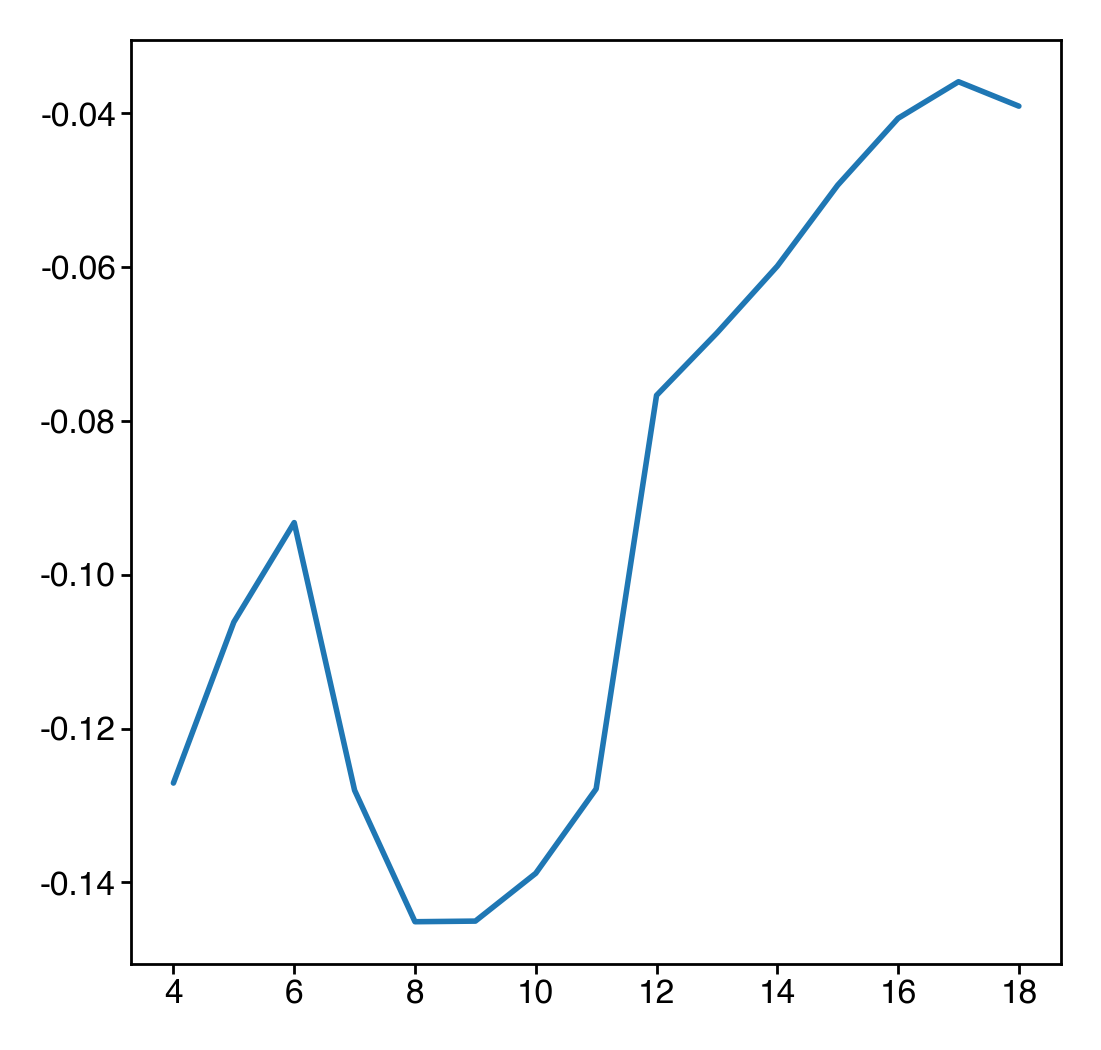

In [30]:
ax = corr_map.plot()
# ax.set(xscale='log')

In [31]:
minimize_corr = corr_map.idxmin()
minimize_corr

8.0

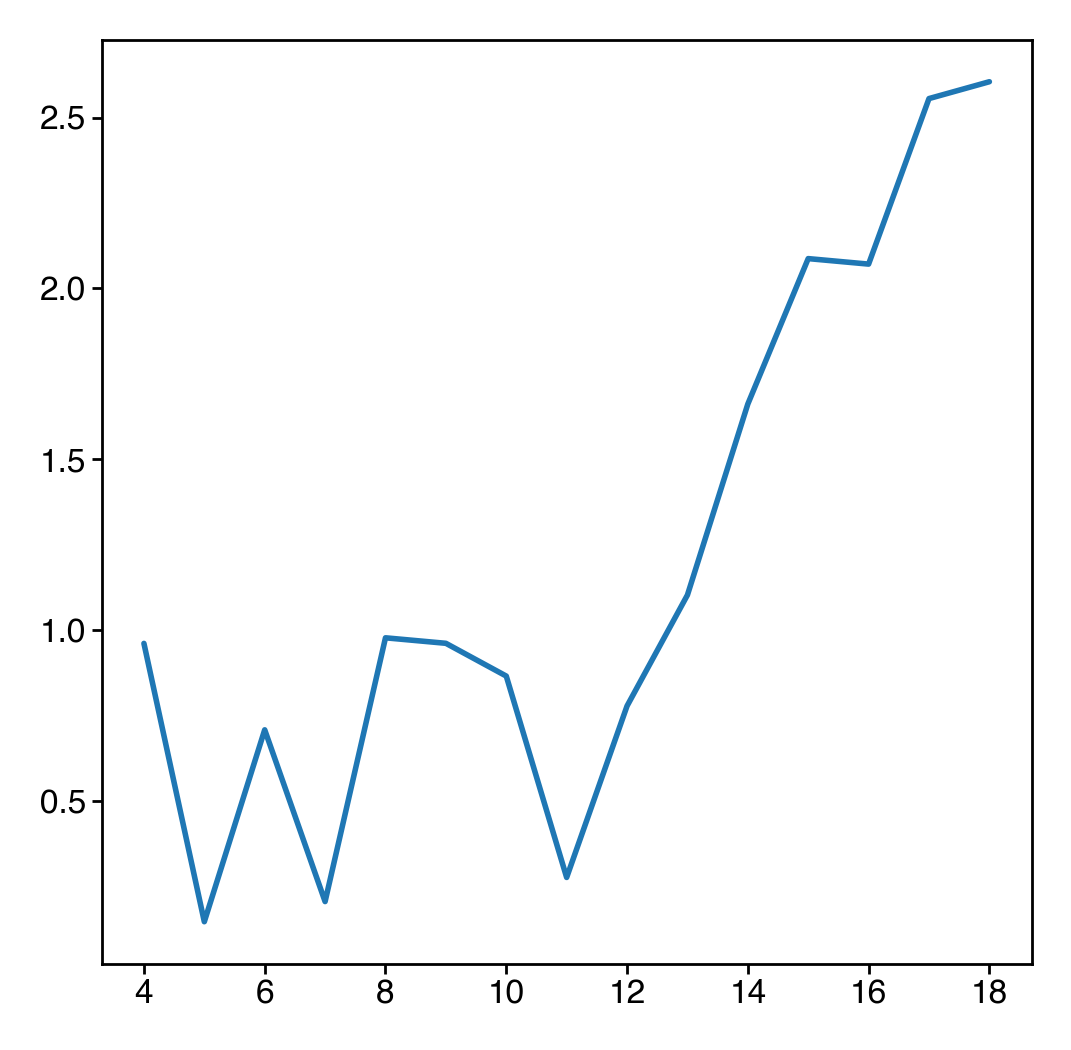

In [32]:
loss = (residual_map - 9.744186 + 0.5).abs()
ax = loss.plot()

In [33]:
hypparams['age_sd'] = float(loss.idxmin())
hypparams['age_sd']

5.0

In [34]:
hypparams['age_sd'] = float(minimize_corr)

In [35]:
mdl = fit_model(features, hypparams, 5, return_loss_on_error=True)
tmp_df['beh_age'] = mdl['bio_ages']

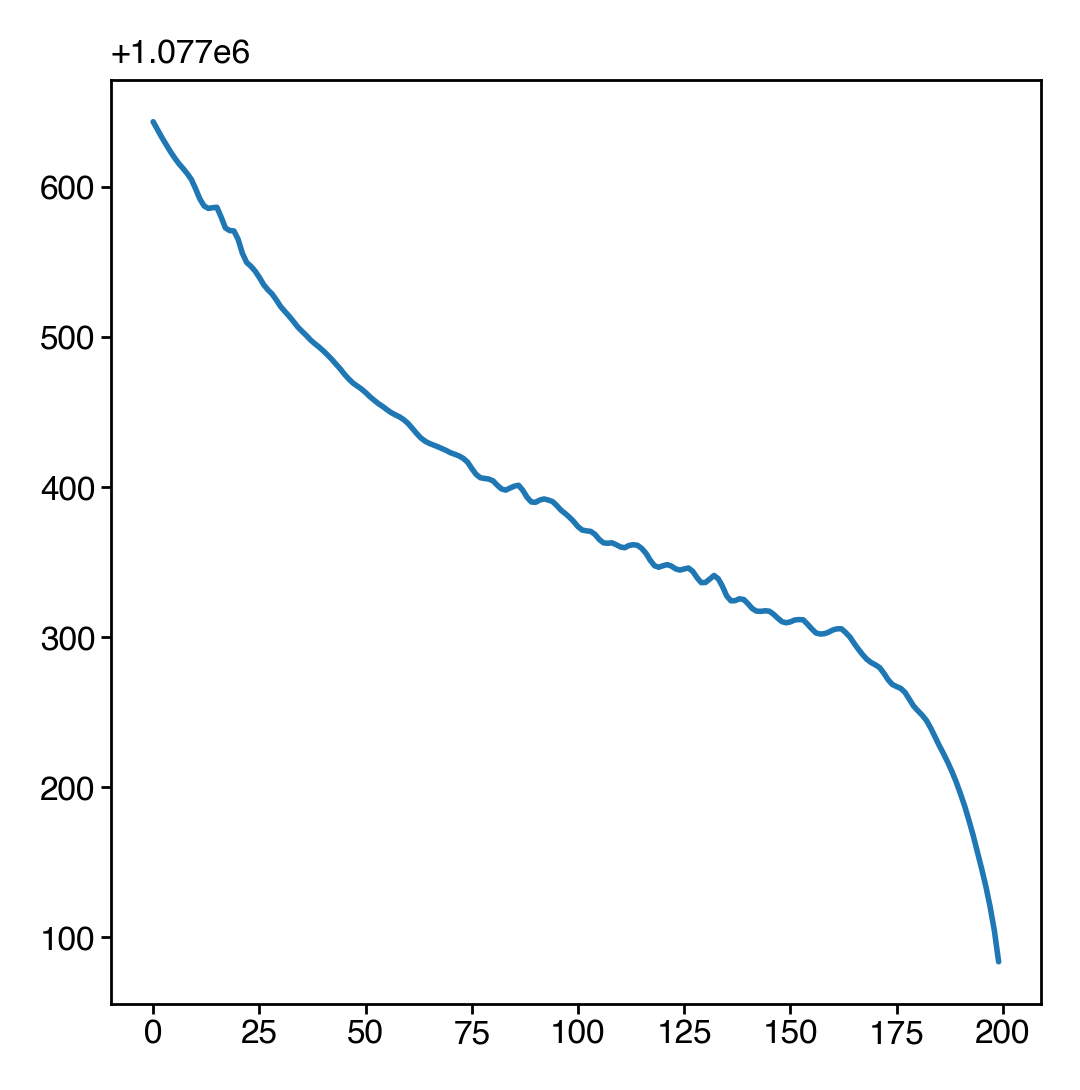

In [36]:
plt.plot(mdl['loss'][100:])

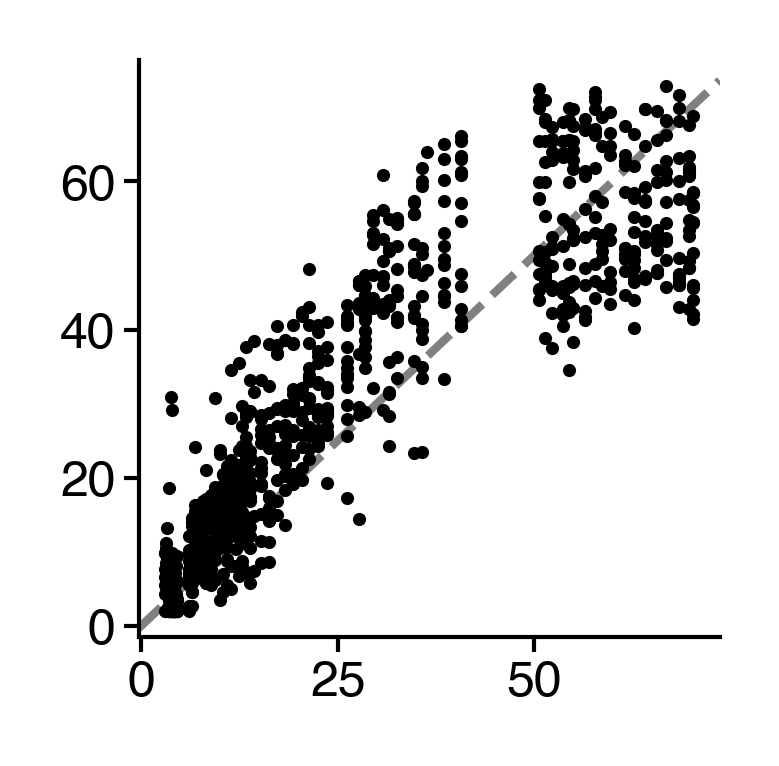

In [37]:
fig = figure(1.25, 1.25)
plt.scatter(mdl['true_ages'], mdl['bio_ages'], c='k', s=2.5, lw=0)
a = add_identity(plt.gca(), c='gray', ls='--', zorder=-1)
sns.despine()

## Join death and behavior

### Make functions for plotting

In [38]:
def fit_classifier(data, n_fits=100):
    accs = []
    for seed in range(n_fits):
        acc, p = compute_classifier(data, seed=seed)
        accs.append(acc)
    print("Observed fit")
    print(n_classes, round(np.log2(np.mean(accs) / (1 / n_classes)), 2))

    # shuffle
    shuffs = []
    for i in tqdm(range(100)):
        shuff_df = data.copy()
        shuff_df['beh_age'] = shuff_df['beh_age'].sample(frac=1, replace=False, random_state=i).to_numpy()
        # shuffle ages within age chunks rather than across everything to remove individual biases
        acc, p = compute_classifier(shuff_df, seed=i)
        shuffs.append(acc)
    print("Shuffle fit")
    print(n_classes, round(np.log2(np.mean(shuffs) / (1 / n_classes)), 2))
    return accs, shuffs

def plot_model(accs, shuffs, name):
    fig = figure(0.55, 1.3)
    ax = sns.boxplot(data=[accs, shuffs], palette=['#333', 'silver'], showfliers=False, showcaps=False)
    ax.axhline(1 / n_classes, color='k', ls='--')
    ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.45))
    ax.tick_params(axis='x', rotation=90)
    sns.despine()
    saver(fig, name)

## Try classifying early/late death times 

In [39]:
subset = make_death_df(tmp_df.reset_index(), 56, 71)
accs, shuffs = fit_classifier(subset)
# plot_model(accs, shuffs, "death-rank-classifier-via-bambi")

Observed fit
4 0.57


  0%|          | 0/100 [00:00<?, ?it/s]

Shuffle fit
4 0.03


In [40]:
subset[['classes', 'beh_age']].corr(method='spearman')

,classes,beh_age
classes,1.000000,-0.176366
beh_age,-0.176366,1.000000


In [41]:
subset[['death_rank', 'beh_age']].corr(method='spearman')

,death_rank,beh_age
death_rank,1.000000,-0.145122
beh_age,-0.145122,1.000000


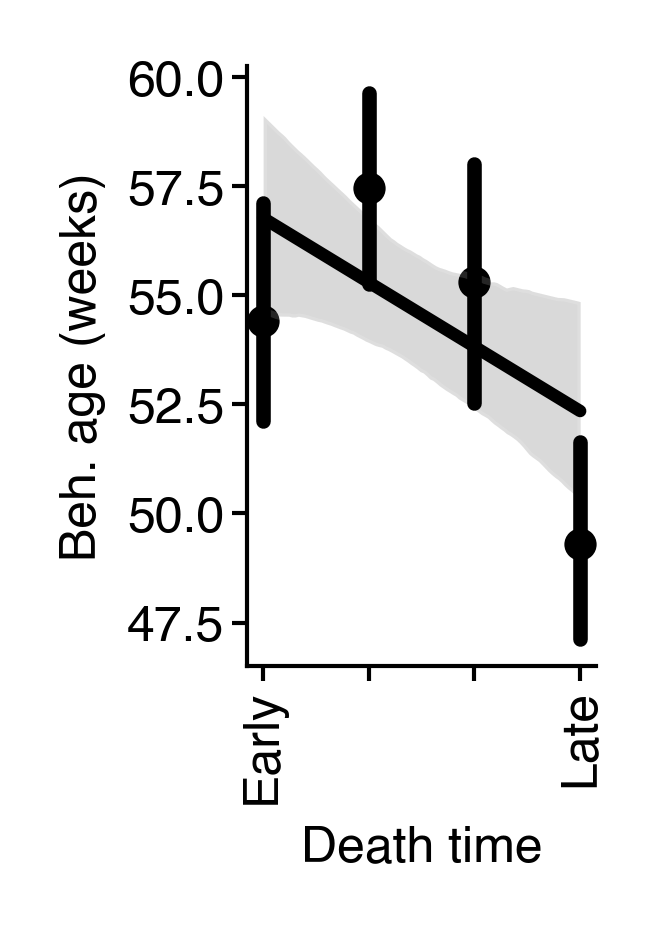

In [42]:
fig = figure(0.75, 1.3)
ax = sns.regplot(data=subset, x='classes', y='beh_age', x_bins=6, scatter_kws=dict(s=15, linewidths=0), color='k')
ax.set(ylabel="Beh. age (weeks)", xlabel="Death time", xticks=[0, 1, 2, 3], xticklabels=['Early', '', '', 'Late'])
ax.tick_params(axis='x', rotation=90)
sns.despine()
# saver(fig, "bambi-beh-age-vs-death");

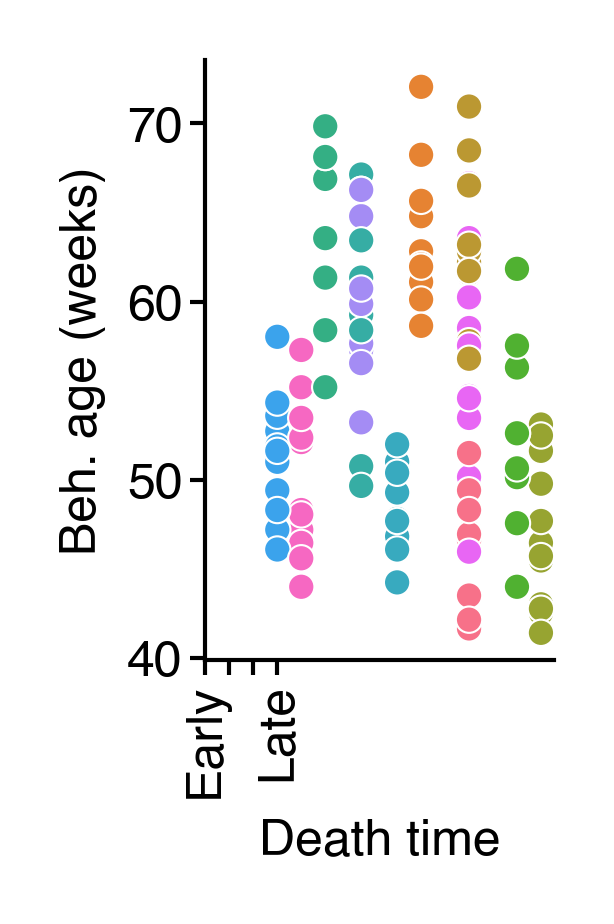

In [43]:
fig = figure(0.75, 1.3)
# ax = sns.regplot(data=subset, x='death_rank', y='beh_age', scatter=False)
ax = sns.scatterplot(data=subset, x='death_rank', y='beh_age', hue='mouse', legend=False, s=10)
# ax = sns.pointplot(data=subset, x='death_rank', y='beh_age', hue='mouse', legend=False)
ax.set(ylabel="Beh. age (weeks)", xlabel="Death time", xticks=[0, 1, 2, 3], xticklabels=['Early', '', '', 'Late'])
ax.tick_params(axis='x', rotation=90)
sns.despine()
# saver(fig, "bambi-beh-age-vs-death");

In [44]:
subset.groupby('mouse').first()['Death'].sort_values()

mouse
03_02   2022-07-10
04_04   2023-08-05
02_02   2023-08-11
02_03   2023-08-15
03_04   2023-08-15
03_01   2023-10-15
01_02   2023-10-28
01_01   2023-12-04
01_03   2023-12-04
04_03   2023-12-04
02_01   2023-12-05
01_04   2024-01-08
Name: Death, dtype: datetime64[ns]

## Some extra visualizations

In [45]:
mouse = subset[subset['Death'] == subset['Death'].min()]
mouse2 = subset[subset['Death'] == subset['Death'].max()]

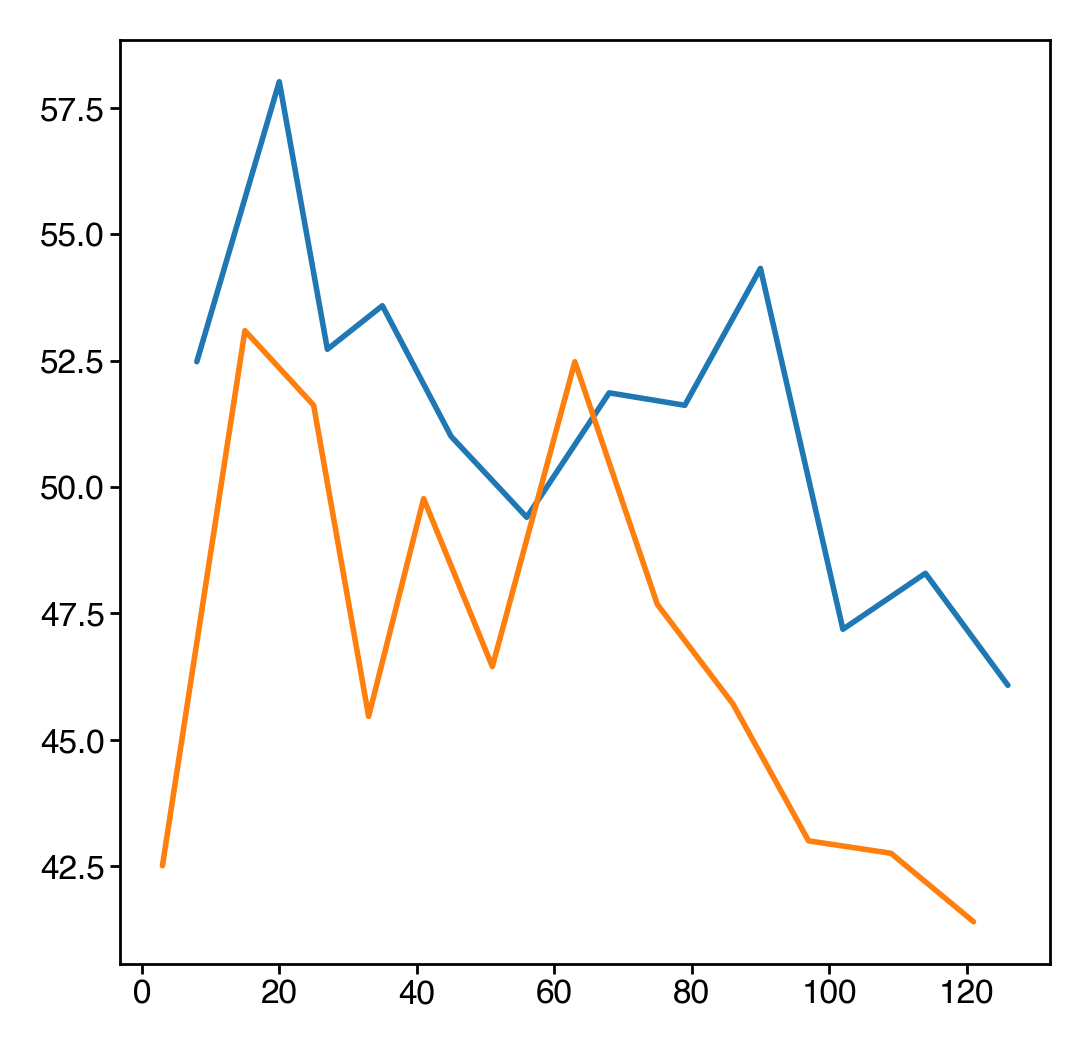

In [46]:
plt.plot(mouse['beh_age'])
plt.plot(mouse2['beh_age'])

In [47]:
sorted_ages = subset.groupby('mouse')['beh_age'].mean().sort_values()

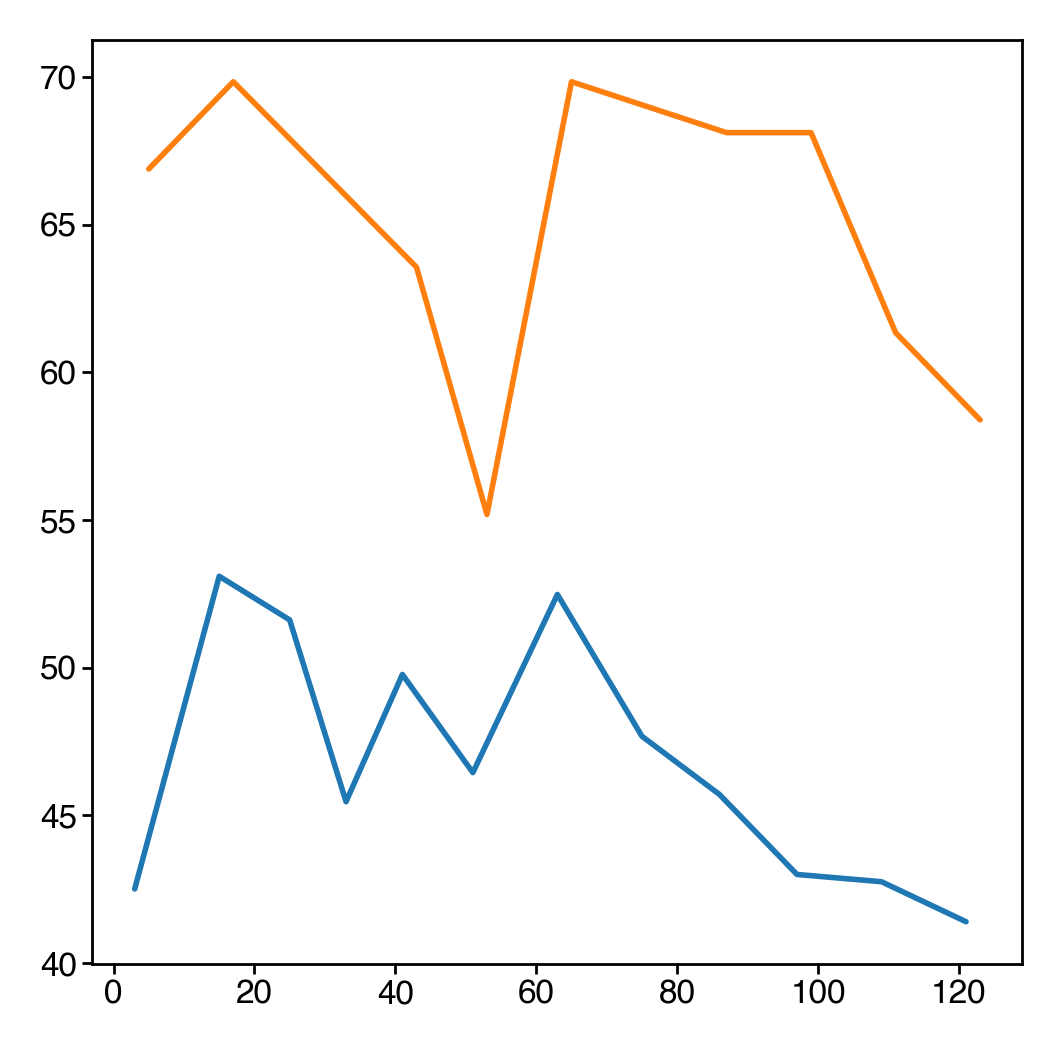

In [48]:
plt.plot(subset.loc[subset['mouse'] == sorted_ages.index[0], 'beh_age'])
plt.plot(subset.loc[subset['mouse'] == sorted_ages.index[-1], 'beh_age'])

## Fit to ontogeny, apply to longtogeny

In [49]:
import jax
import joblib
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from tqdm.auto import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PLOT_CONFIG,
    save_factory,
    COLORMAPS,
)
from copy import deepcopy
from operator import or_
from toolz import reduce, valmap, keyfilter, pluck
from aging.behavior.bio_age_model import (
    fit_model,
    masked_xval,
    raise_dim,
    constrained_fit
)
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA, NMF
from scipy.stats import ks_2samp
from itertools import product
from scipy.stats import norm
from itertools import combinations

In [50]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_


def minmax(df):
    return (df - df.min()) / (df.max() - df.min())

In [51]:
def make_plot(age_df, width, height):
    boundaries = np.arange(age_df["labels"].max() + 2) - 0.5
    pal = sns.blend_palette([COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)], as_cmap=True)
    fig = figure(width, height)
    ax = sns.lineplot(
        data=age_df,
        x="true_ages",
        y="bio_ages",
        hue="labels",
        palette=[COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)],
        legend=False,
        zorder=-1,
        lw=0.25,
        err_kws=dict(lw=0),
    )
    perm = np.random.permutation(len(age_df))
    im = ax.scatter(
        age_df["true_ages"].iloc[perm],
        age_df["bio_ages"].iloc[perm],
        c=age_df["labels"].iloc[perm],
        cmap=pal,
        vmin=0,
        vmax=1,
        s=1,
    )
    cb = fig.colorbar(
        mappable=im,
        boundaries=boundaries,
        ax=ax,
        label="Sex",
    )
    cb.set_ticks(range(0, 2))
    cb.set_ticklabels(["Male", "Female"])
    add_identity(ax, c="k", ls="--", zorder=-2)
    ax.set(
        xlabel="Chronological age (weeks)",
        ylabel="Behavioral age (weeks)",
        aspect="equal",
        xlim=(0, 120),
    )
    sns.despine()
    return fig

In [52]:
def read_male_ontogeny(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_counts_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]
    df = df[use_syllables]
    return df, sizes_col

In [54]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

In [55]:
df, sizes_col = read_male_ontogeny(keep_syllables)

age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))

sort_idx = np.argsort(syllable_counts_jax.mean(0))[::-1]

In [190]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": sizes_col.to_numpy()
}

age_sd = 0.16

hypparams = {
    "log_age": True,
    "min_age": 2,
    "max_age": 125,
    "age_sd": age_sd,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "scale": 150,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.25,
    "n_opt_iter": 100,
    "log_scale_sd": True,
}

## Fit age + size model on male ontogeny data 

In [191]:
mdl = fit_model(features, hypparams, 2, return_loss_on_error=False)

if len(mdl) == 1:
    print(hypparams['n_opt_iter'] - np.isnan(mdl['loss']).sum())

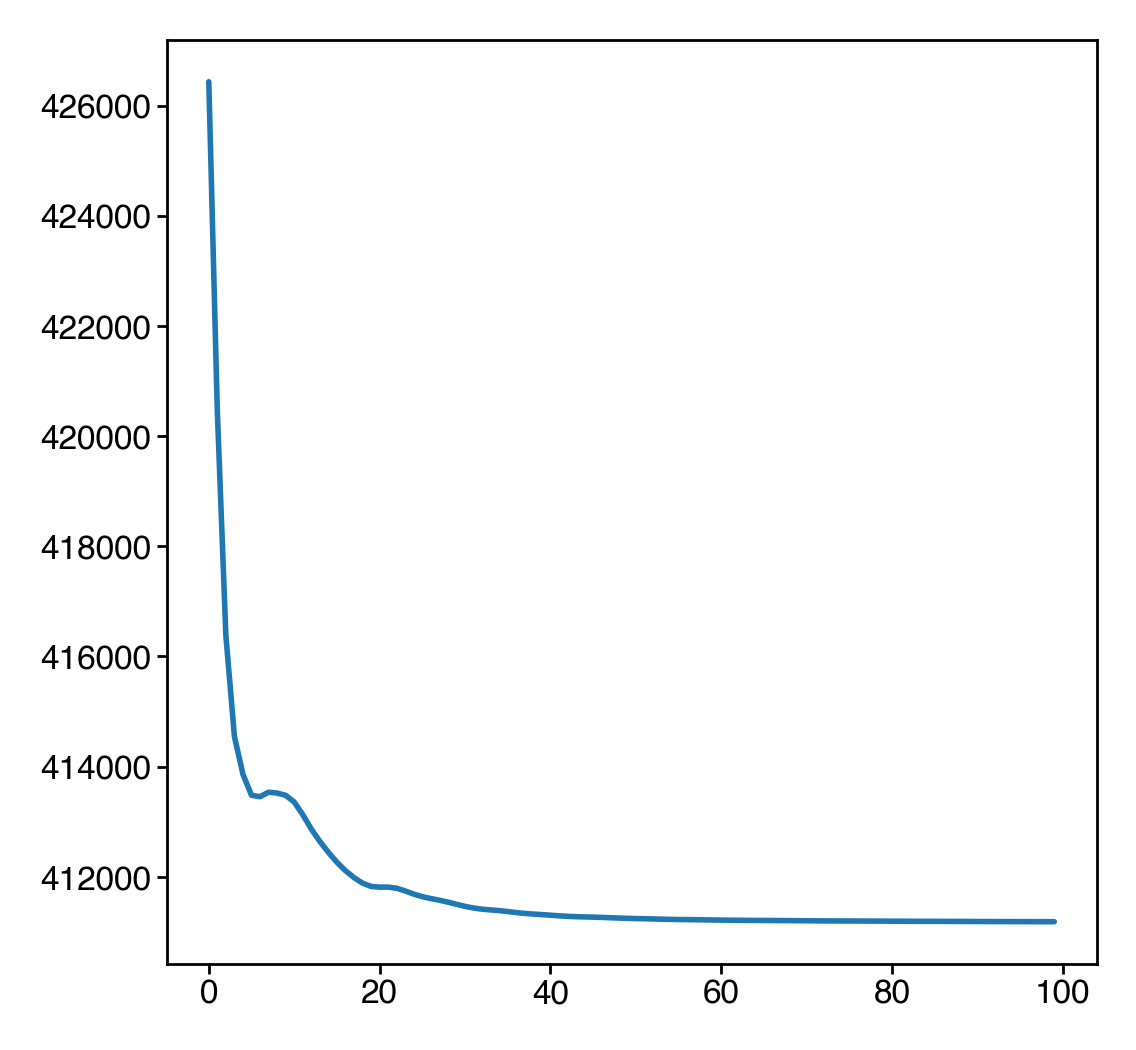

In [192]:
plt.plot(mdl['loss'])

## Fit a constrained model on wheel data

- Only fit the individuality parameter

In [193]:
(
    tmp_df,
    long_syllable_counts_jax,
    long_age,
    long_size_col,
    long_mouse_ids,
    sort_idx,
    long_labels,
) = load_long_df2(None)

In [194]:
wheel_features = {
    "ages": jnp.array(long_age, dtype=jnp.float32),  # models >= 1
    "counts": long_syllable_counts_jax + 1,  # models >= 1
    "sizes": jnp.array(long_size_col),
    "mice": jnp.array(long_mouse_ids),
}

wheel_hypparams = deepcopy(hypparams)
wheel_hypparams["n_animals"] = len(long_mouse_ids)
wheel_hypparams['n_opt_iter'] = 50

# this forces the identity factors to incorporate an experiment-specific
# syllable offset to account for "batch effects"
wheel_hypparams['zero_mean'] = False

In [195]:
fixed_params = mdl['params']

In [196]:
list(fixed_params)

['bio_basis_weights', 'size_slope']

In [197]:
long_mdl = constrained_fit(wheel_features, fixed_params, wheel_hypparams, 5, return_loss_on_error=False)

In [198]:
if len(long_mdl) == 1:
    print(wheel_hypparams['n_opt_iter'] - np.isnan(long_mdl['loss']).sum())

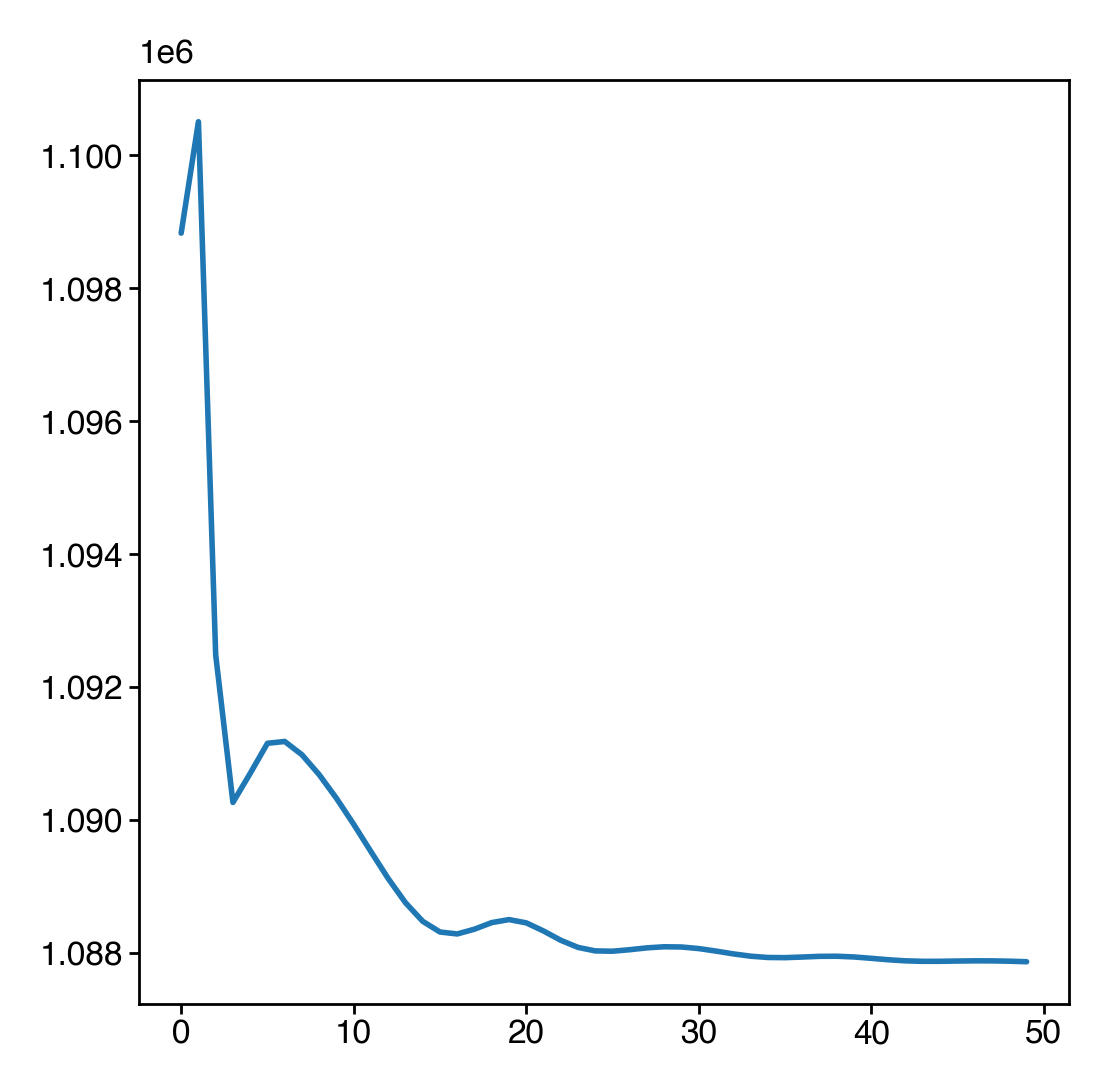

In [199]:
plt.plot(long_mdl['loss'])

In [200]:
list(long_mdl['params'])

['development_weights', 'individual_biases', 'bio_basis_weights', 'size_slope']

In [201]:
ind_bias = raise_dim(long_mdl['params']['individual_biases'], axis=1)

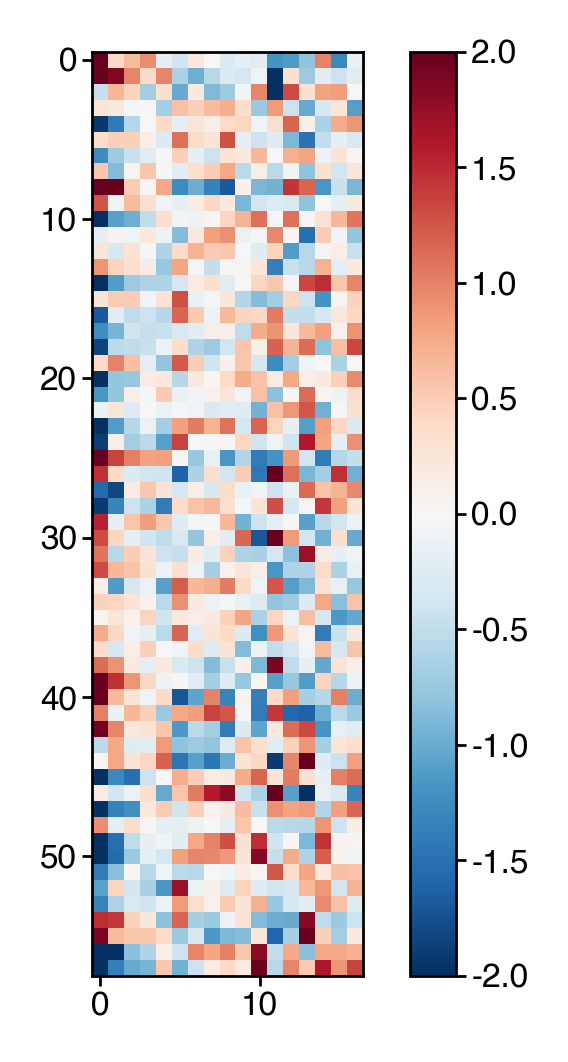

In [202]:
plt.imshow(ind_bias, cmap='RdBu_r', vmin=-2, vmax=2)
plt.colorbar()

<Axes: >

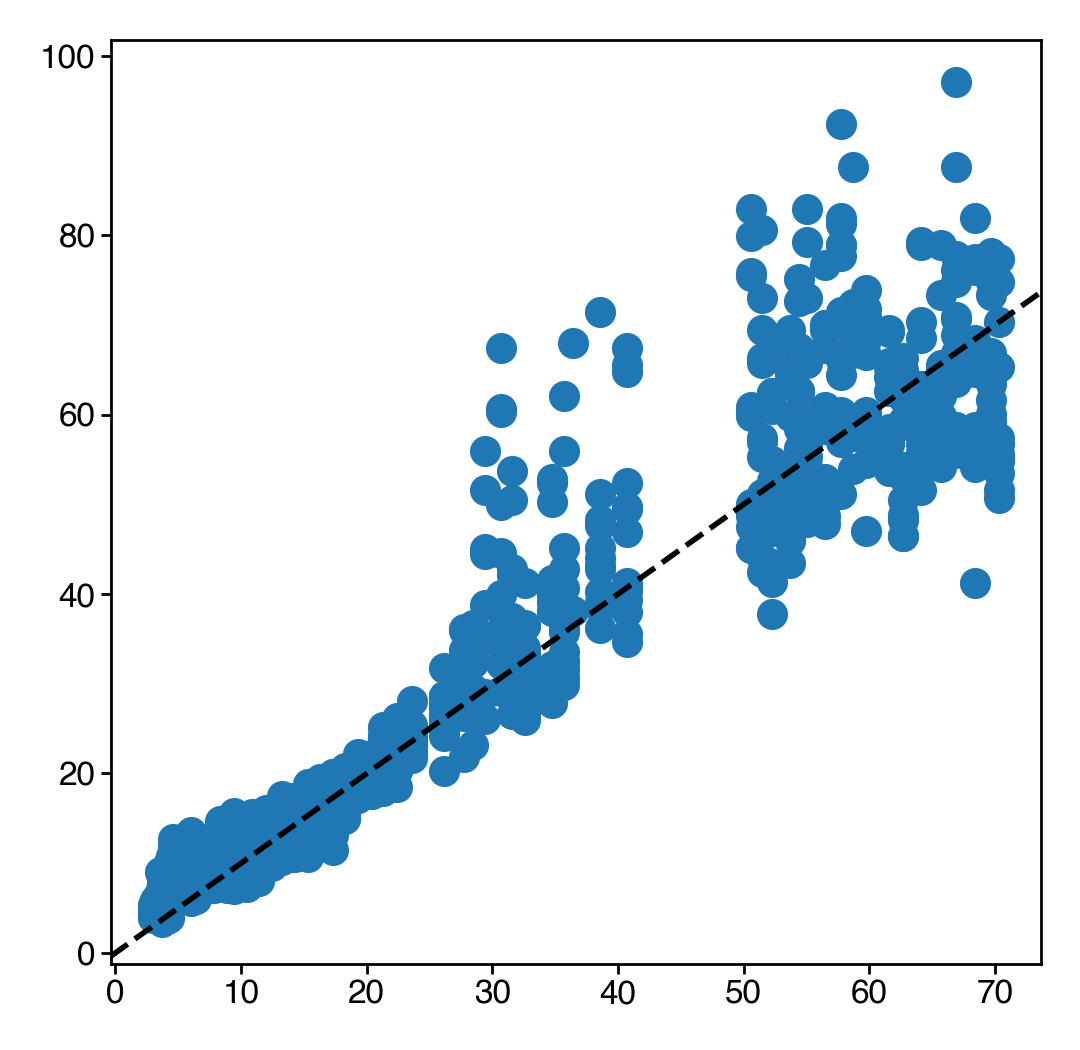

In [203]:
plt.scatter(long_mdl['true_ages'], long_mdl['bio_ages'])
add_identity(plt.gca(), color='k', ls='--')

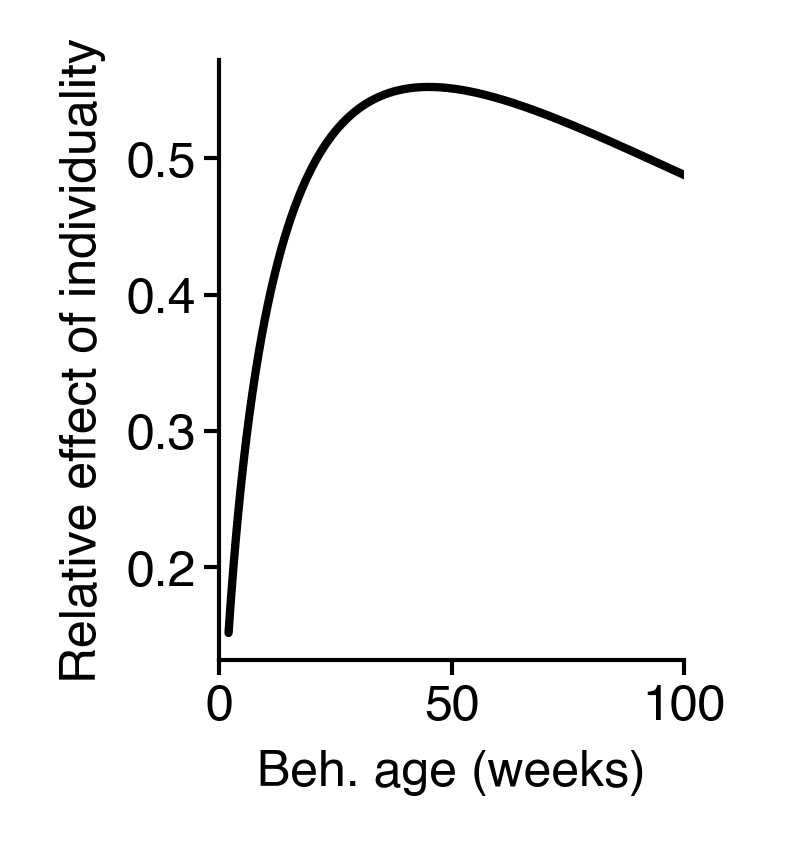

In [204]:
comps = long_mdl['init_components']

x = long_mdl['params']['development_weights']
dev = np.exp(x @ comps.bases['development']).squeeze()

fig = figure(1, 1.3)
ax = fig.gca()
ax.plot(comps.age_unnormalizer(comps.age_samples), dev, color='k')
plt.xlim(0, 100)
# plt.ylim(0, None)
plt.xlabel("Beh. age (weeks)")
plt.ylabel("Relative effect of individuality")
sns.despine()

## Make dataframe

In [205]:
tmp_df['beh_age'] = long_mdl['bio_ages']

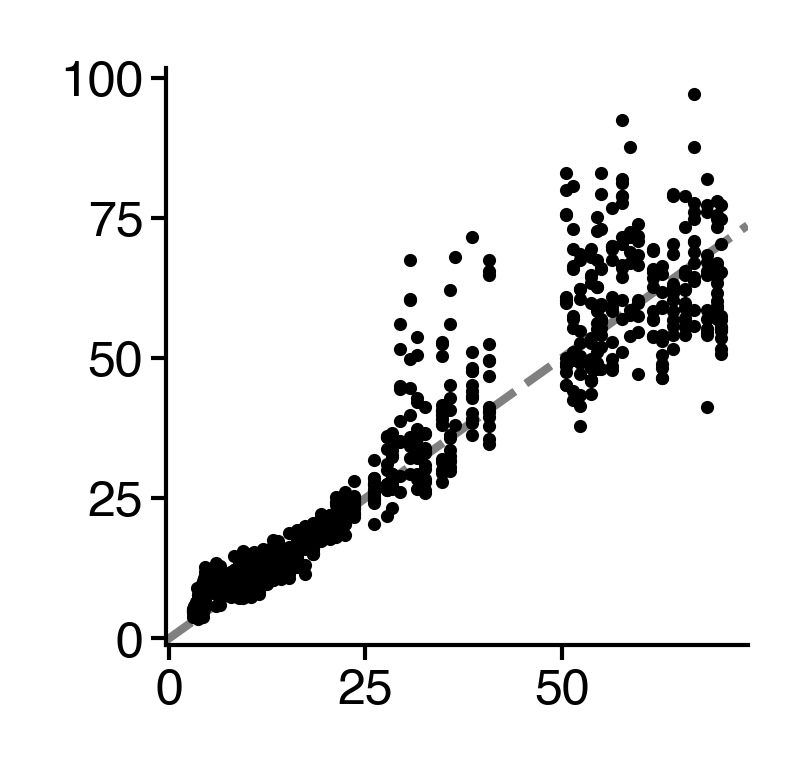

In [206]:
fig = figure(1.25, 1.25)
plt.scatter(long_mdl['true_ages'], long_mdl['bio_ages'], c='k', s=2.5, lw=0)
a = add_identity(plt.gca(), c='gray', ls='--', zorder=-1)
sns.despine()

## Join death and behavior

## Try classifying early/late death times 

In [207]:
subset = make_death_df(tmp_df.reset_index(), 56, 71)
accs, shuffs = fit_classifier(subset)
# plot_model(accs, shuffs, "death-rank-classifier-via-bambi")

Observed fit
4 0.42


  0%|          | 0/100 [00:00<?, ?it/s]

Shuffle fit
4 -0.05


In [208]:
subset[['classes', 'beh_age']].corr(method='spearman')

,classes,beh_age
classes,1.000000,-0.149644
beh_age,-0.149644,1.000000


In [209]:
subset[['death_rank', 'beh_age']].corr(method='spearman')

,death_rank,beh_age
death_rank,1.000000,-0.150292
beh_age,-0.150292,1.000000


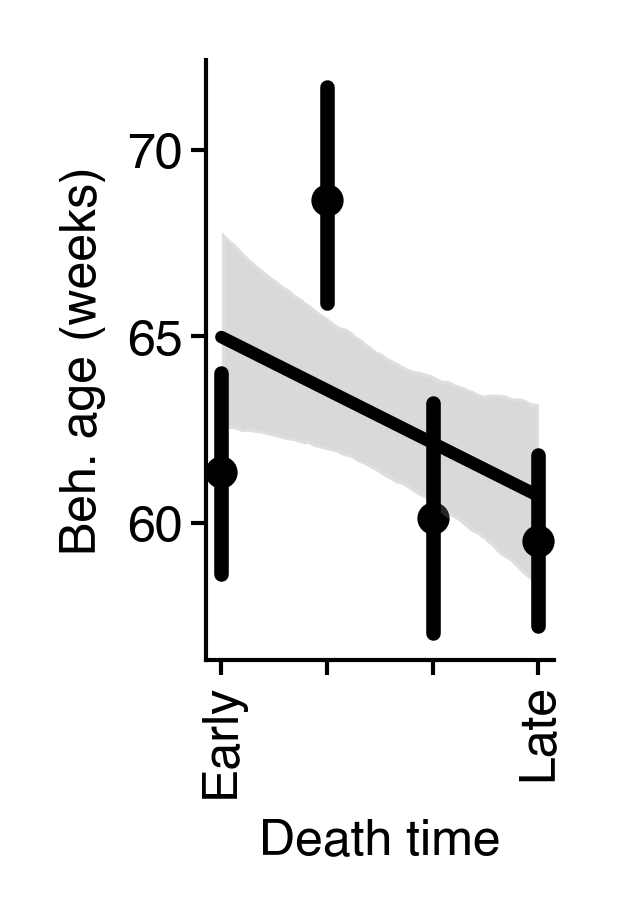

In [210]:
fig = figure(0.75, 1.3)
ax = sns.regplot(data=subset, x='classes', y='beh_age', x_bins=6, scatter_kws=dict(s=15, linewidths=0), color='k')
ax.set(ylabel="Beh. age (weeks)", xlabel="Death time", xticks=[0, 1, 2, 3], xticklabels=['Early', '', '', 'Late'])
ax.tick_params(axis='x', rotation=90)
sns.despine()
# saver(fig, "bambi-beh-age-vs-death");

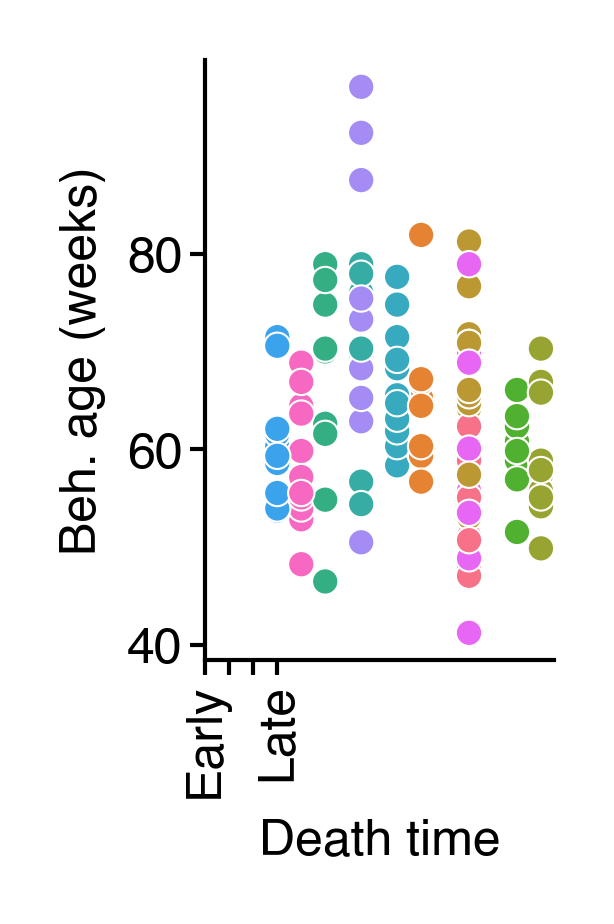

In [211]:
fig = figure(0.75, 1.3)
# ax = sns.regplot(data=subset, x='death_rank', y='beh_age', scatter=False)
ax = sns.scatterplot(data=subset, x='death_rank', y='beh_age', hue='mouse', legend=False, s=10)
# ax = sns.pointplot(data=subset, x='death_rank', y='beh_age', hue='mouse', legend=False)
ax.set(ylabel="Beh. age (weeks)", xlabel="Death time", xticks=[0, 1, 2, 3], xticklabels=['Early', '', '', 'Late'])
ax.tick_params(axis='x', rotation=90)
sns.despine()
# saver(fig, "bambi-beh-age-vs-death");